In [72]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import sys


In [73]:
# Function to count digits in folder name for labels




data_path = os.path.join('..', '..', 'data', 'external', 'double_mnist')

def get_digit_count(label_name):
    return len(label_name)

def load_mnist_data(data_path):
    data_splits = ['train', 'val', 'test']
    data = {}

    for split in data_splits:
        images, labels = [], []
        split_path = os.path.join(data_path, split)
        
        # Iterate over each subfolder in the split directory
        for label_folder in os.listdir(split_path):
            folder_path = os.path.join(split_path, label_folder)
            
            if os.path.isdir(folder_path):
                # If the folder is "0", assign label 0 for blank images
                if label_folder == "0":
                    label = 0  # No digits in the image
                else:
                    # Otherwise, label is the count of digits in the folder name (e.g., "123" -> label 3)
                    label = get_digit_count(label_folder)
                
                # Load each image in the folder
                for image_name in os.listdir(folder_path):
                    if image_name.endswith(('.png', '.jpg')):  # Ensure image file
                        image_path = os.path.join(folder_path, image_name)
                        image = Image.open(image_path).convert("L")  # Convert to grayscale
                        images.append(image)
                        labels.append(label)
        
        data[split] = (images, labels)

    return data['train'], data['val'], data['test']

In [74]:
train_data, val_data, test_data = load_mnist_data(data_path)

In [75]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define any transformations if needed, e.g., resize, normalize
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create dataset instances
train_dataset = MultiMNISTDataset(train_data[0], train_data[1], transform=transform)
val_dataset = MultiMNISTDataset(val_data[0], val_data[1], transform=transform)
test_dataset = MultiMNISTDataset(test_data[0], test_data[1], transform=transform)

# Create data loaders for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

First image shape: (128, 128)
First label: 2


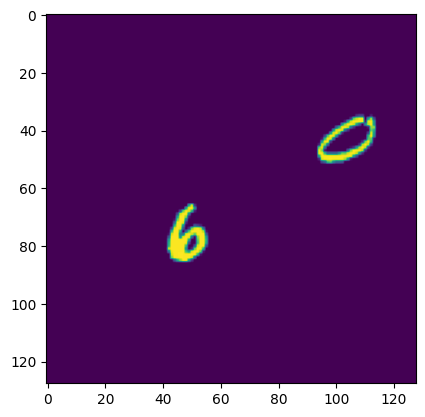

In [76]:

first_image = train_data[0][7849]
first_label = train_data[1][7849]

print(f"First image shape: {np.array(first_image).shape}")  # Show the shape of the first image
print(f"First label: {first_label}")
plt.imshow(first_image)

In [77]:
# Replace `__file__` with the current working directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../models/CNN')))
from cnn import MultiTaskCNN

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from sklearn.metrics import mean_squared_error

In [79]:
# For classification task
model_classification = MultiTaskCNN(task='classification')

# For regression task
model_regression = MultiTaskCNN(task='regression')


# Classification loss and optimizer
criterion_classification = nn.CrossEntropyLoss()
optimizer_classification = optim.Adam(model_classification.parameters(), lr=0.001)

# Regression loss and optimizer
criterion_regression = nn.MSELoss()
optimizer_regression = optim.Adam(model_regression.parameters(), lr=0.001)


In [80]:
# Training loop for classification task
num_epochs = 10
model_classification.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer_classification.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model_classification(images)
        loss = criterion_classification(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer_classification.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")


Epoch 1/10, Loss: 0.42216444055849406
Epoch 2/10, Loss: 0.008935192566749153
Epoch 3/10, Loss: 0.0006142968332791922
Epoch 4/10, Loss: 8.313270906822757e-05
Epoch 5/10, Loss: 5.154363562149247e-05
Epoch 6/10, Loss: 3.0278080451210042e-05
Epoch 7/10, Loss: 1.934538137093483e-05
Epoch 8/10, Loss: 1.414420633318283e-05
Epoch 9/10, Loss: 1.2817589404890933e-05
Epoch 10/10, Loss: 9.092628398983889e-06


In [81]:
# Evaluation for classification
model_classification.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for images, labels in val_loader:
        outputs = model_classification(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total}%')

Validation Accuracy: 100.0%


Displaying image of shape: torch.Size([28, 28])


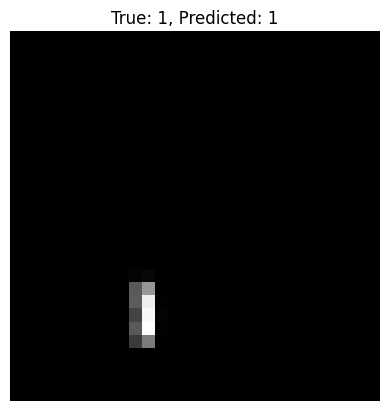

Displaying image of shape: torch.Size([28, 28])


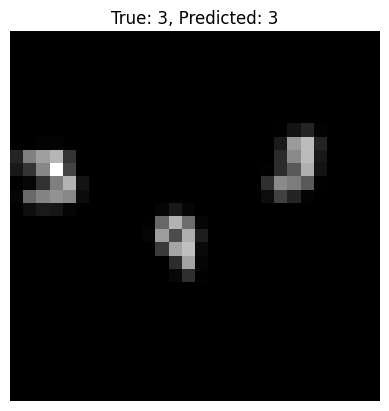

Displaying image of shape: torch.Size([28, 28])


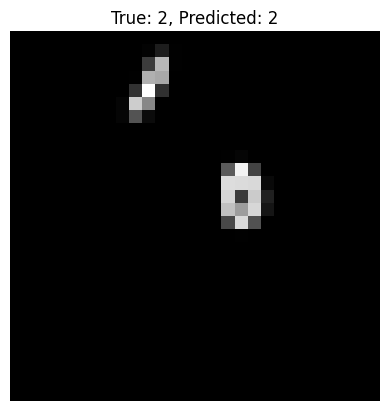

Displaying image of shape: torch.Size([28, 28])


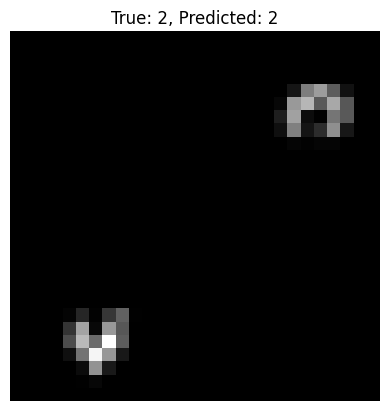

Displaying image of shape: torch.Size([28, 28])


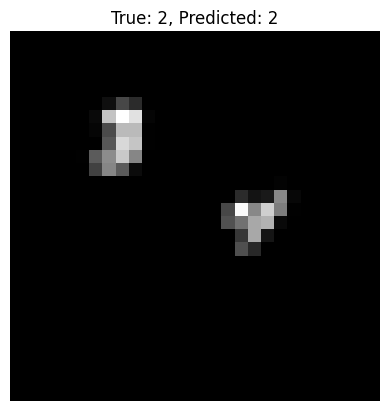

In [82]:
import random

# Evaluation for classification with random output visualization
model_classification.eval()  # Set model to evaluation mode

# List to store non-blank samples
non_blank_samples = []
non_blank_labels = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in val_loader:
        outputs = model_classification(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if labels[i].item() > 0:  # Only include non-blank images (label > 0)
                non_blank_samples.append(images[i])
                non_blank_labels.append((labels[i].item(), predicted[i].item()))

# Select 5 random non-blank samples
random_indices = random.sample(range(len(non_blank_samples)), 5)

# Print results for the randomly selected samples
for idx in random_indices:
    image_to_display = non_blank_samples[idx].squeeze()  # Assuming single channel (grayscale)
    print(f"Displaying image of shape: {image_to_display.shape}")  # Check image shape
    plt.imshow(image_to_display, cmap='gray')  # Display the original image
    true_label, predicted_label = non_blank_labels[idx]
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')  # Hide axes
    plt.show()  # Display image

Its giving 100% validation accuracy for my base classifier , for what am I supposed to tune the hyper parameters for?
I will take 5 combinations and print the loss graphs for each.

In [90]:
import random

# Define hyperparameter options
learning_rates = [0.001, 0.01, 0.0001]
optimizers = ['adam', 'sgd']
weight_decays = [0.0, 0.01, 0.001]

# Generate all possible combinations
all_combinations = []
for lr in learning_rates:
    for optimizer in optimizers:
        for wd in weight_decays:
            all_combinations.append((lr, optimizer, wd))

# Randomly select 5 unique combinations
random_combinations = random.sample(all_combinations, 5)

print("Random Hyperparameter Combinations (Disjoint):")
for combination in random_combinations:
    print(combination)

Random Hyperparameter Combinations (Disjoint):
(0.001, 'adam', 0.01)
(0.001, 'sgd', 0.001)
(0.01, 'adam', 0.0)
(0.001, 'sgd', 0.01)
(0.001, 'adam', 0.001)


The hyper parameters to train mentioned were number of convolution layers and dropout rate along with lr optimiser type , I cannot do the drop rate one because my cnn model is simpler and doesnt have any dropout layers. as for the convolution layers , they arent modifiable inside the class since no such modifiability(it only asked us to define the layers , not to make them dynamic according to the input) was mentioned during creation of the CNN class , so I chose to do lr optimiser choice and weight decay.


In [91]:
import matplotlib.pyplot as plt

# Store results
results = []

for lr, optimizer_name, weight_decay in random_combinations:
    # Initialize the model
    model_classification = MultiTaskCNN(task='classification')

    # Set the optimizer
    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model_classification.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model_classification.parameters(), lr=lr, weight_decay=weight_decay)

    # Set up loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model_classification.train()
        epoch_train_loss = 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model_classification(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validate
        model_classification.eval()
        epoch_val_loss = 0
        
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_outputs = model_classification(val_images)
                val_loss = criterion(val_outputs, val_labels)
                epoch_val_loss += val_loss.item()

        val_losses.append(epoch_val_loss / len(val_loader))
    
    # Store the results with hyperparameters
    results.append((lr, optimizer_name, weight_decay, train_losses, val_losses))

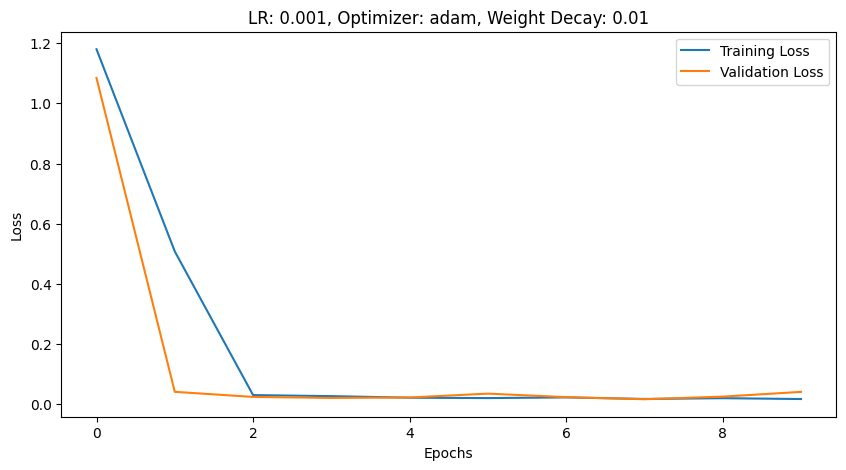

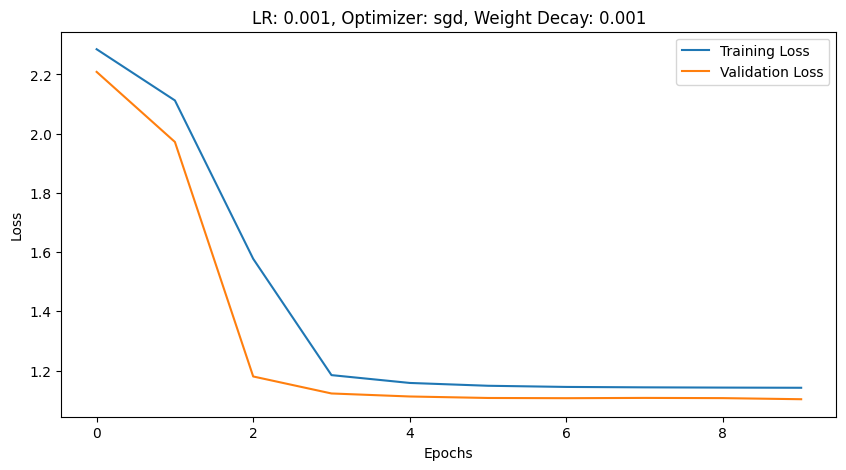

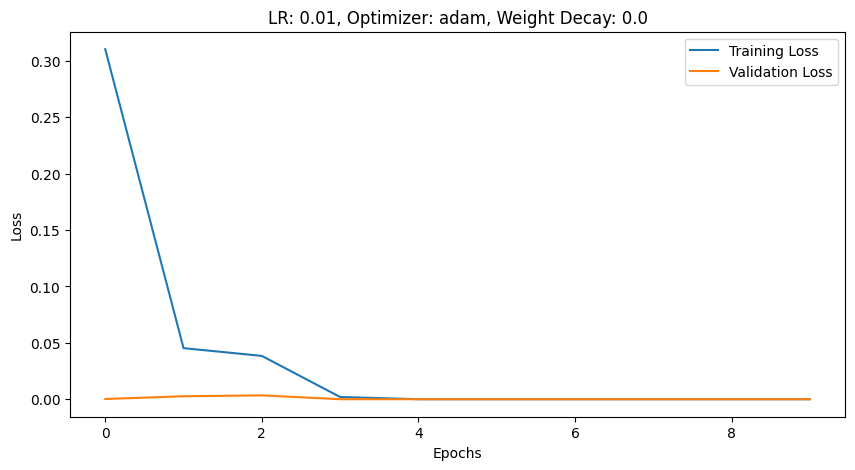

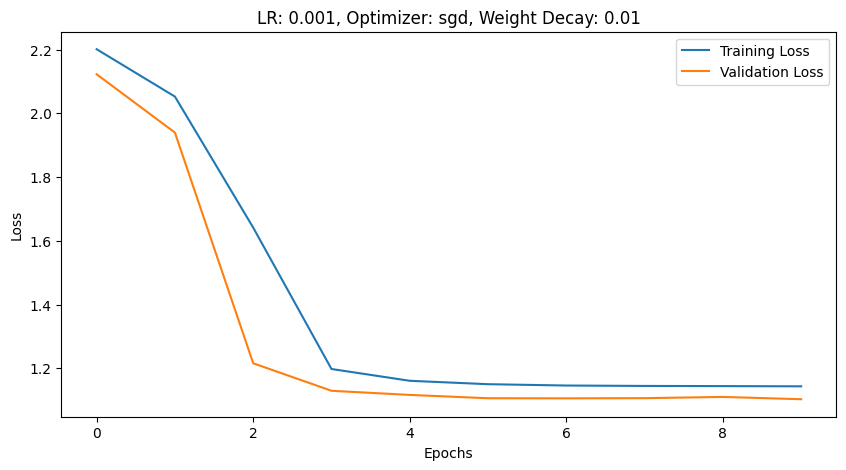

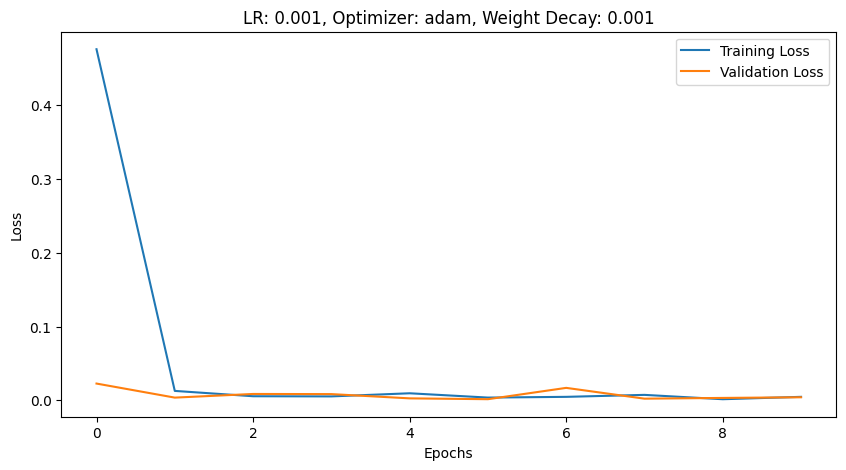

In [92]:
for lr, optimizer_name, weight_decay, train_losses, val_losses in results:
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'LR: {lr}, Optimizer: {optimizer_name}, Weight Decay: {weight_decay}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [93]:
# Training loop for regression task
num_epochs = 10
model_regression.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer_regression.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model_regression(images).squeeze()  # Output is a single regression value
        loss = criterion_regression(outputs, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer_regression.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/10, Loss: 0.2370227485077295
Epoch 2/10, Loss: 0.016789866042876533
Epoch 3/10, Loss: 0.008395764275588719
Epoch 4/10, Loss: 0.005802337128106448
Epoch 5/10, Loss: 0.005324677380421175
Epoch 6/10, Loss: 0.003970984347356096
Epoch 7/10, Loss: 0.004248641442264038
Epoch 8/10, Loss: 0.0031279325157257394
Epoch 9/10, Loss: 0.002698746167547613
Epoch 10/10, Loss: 0.002293292754199734


In [94]:
# Evaluation for regression
model_regression.eval()  # Set model to evaluation mode
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model_regression(images).squeeze()
        all_predictions.extend(outputs.tolist())
        all_labels.extend(labels.tolist())

mse = mean_squared_error(all_labels, all_predictions)
print(f'Validation MSE: {mse}')

Validation MSE: 0.0015358424791596312


In [100]:
# Define hyperparameter options (same as classification)
learning_rates = [0.001, 0.01, 0.0001]
optimizers = ['adam', 'sgd']
weight_decays = [0.0, 0.01, 0.001]

# Generate all possible combinations
all_combinations = []
for lr in learning_rates:
    for optimizer in optimizers:
        for wd in weight_decays:
            all_combinations.append((lr, optimizer, wd))

# Randomly select 5 unique combinations
random_combinations = random.sample(all_combinations, 5)

print("Random Hyperparameter Combinations (Disjoint):")
for combination in random_combinations:
    print(combination)

Random Hyperparameter Combinations (Disjoint):
(0.001, 'adam', 0.01)
(0.01, 'adam', 0.01)
(0.001, 'sgd', 0.0)
(0.001, 'sgd', 0.001)
(0.0001, 'sgd', 0.01)


In [101]:
# Store results for regression
regression_results = []

for lr, optimizer_name, weight_decay in random_combinations:
    # Initialize the model for regression
    model_regression = MultiTaskCNN(task='regression')

    # Set the optimizer
    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model_regression.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model_regression.parameters(), lr=lr, weight_decay=weight_decay)

    # Set up loss function for regression
    criterion = nn.MSELoss()  # Mean Squared Error for regression

    # Train the model
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model_regression.train()
        epoch_train_loss = 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model_regression(images)
            loss = criterion(outputs, labels.float())  # Ensure labels are float for regression
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validate
        model_regression.eval()
        epoch_val_loss = 0
        
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_outputs = model_regression(val_images)
                val_loss = criterion(val_outputs, val_labels.float())  # Ensure labels are float for regression
                epoch_val_loss += val_loss.item()

        val_losses.append(epoch_val_loss / len(val_loader))
    
    # Store the results with hyperparameters
    regression_results.append((lr, optimizer_name, weight_decay, train_losses, val_losses))

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


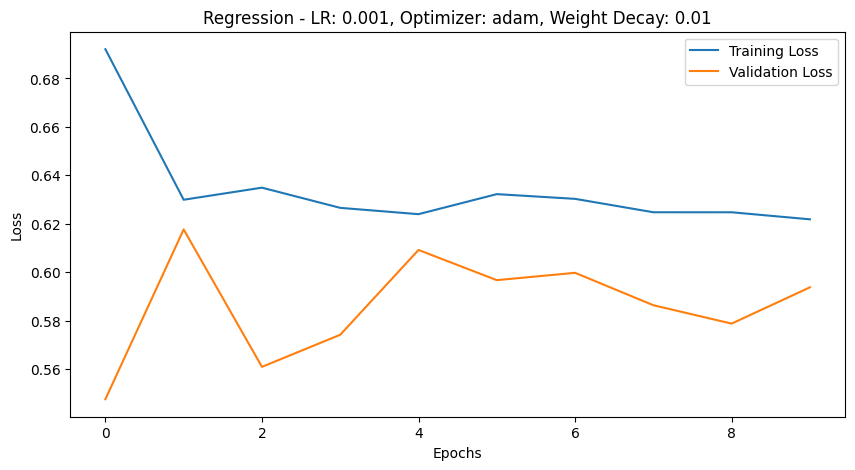

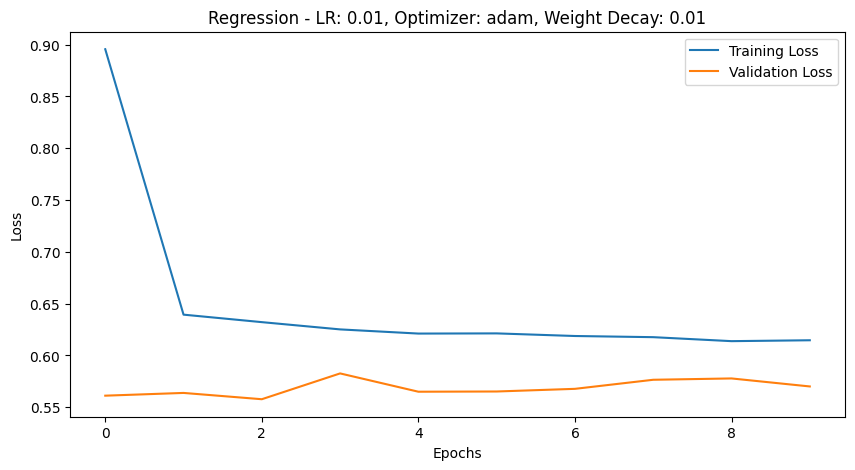

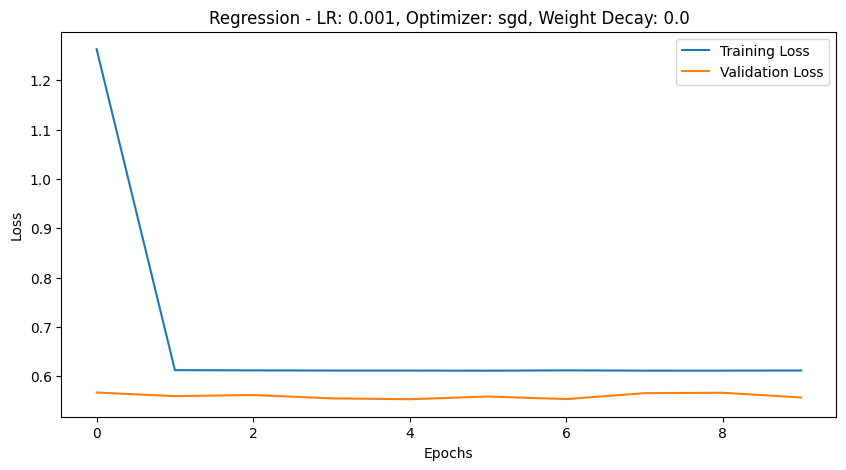

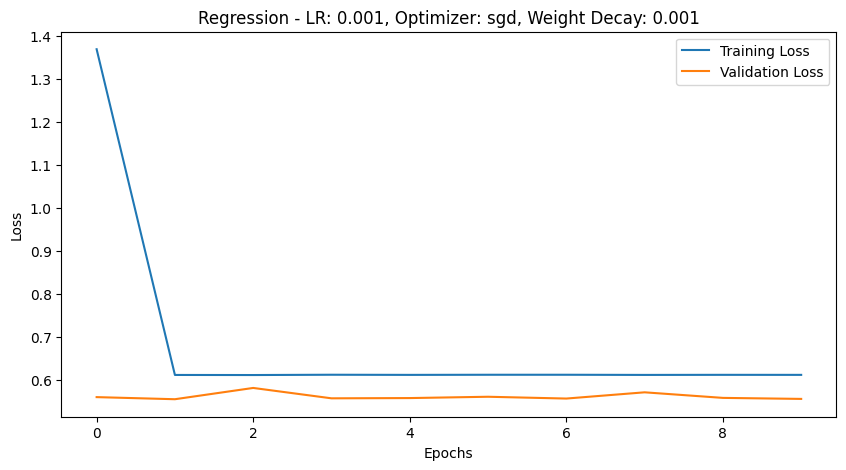

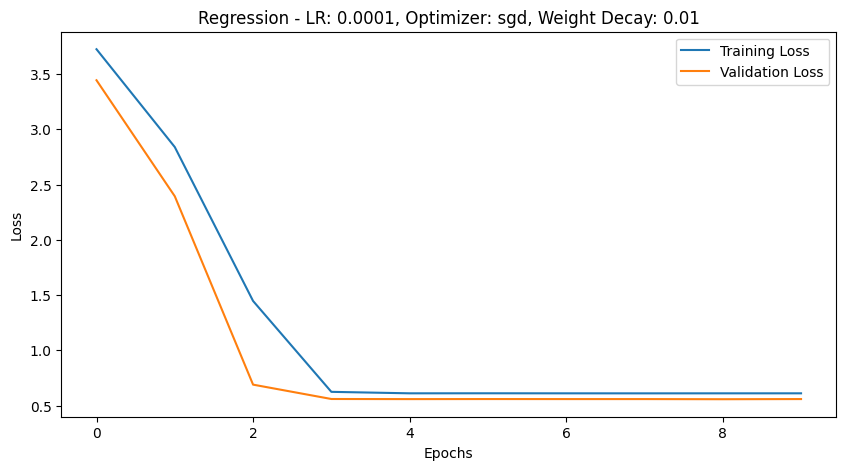

In [102]:
for lr, optimizer_name, weight_decay, train_losses, val_losses in regression_results:
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Regression - LR: {lr}, Optimizer: {optimizer_name}, Weight Decay: {weight_decay}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Based on the results I can say for classification , lr 0.01 optimiser adam and no weight decay is the best

for Regression , lr = 0.001 optimiser adam and weight decay = 0.01 is the best combination out of the 5 random ones i tried.
